In [1]:
import scipy as sp
import scipy.io
import os
import numpy as np
import pandas as pd
import glob
import csv
import random as rand
from tqdm import tnrange, tqdm_notebook
from collections import Iterable
import matplotlib.pylab as mpl
import random as rand
from ipywidgets import *
import colorlover as cl
from scipy import stats
import importlib
import sys
sys.path.append(os.getcwd()+'\\..')
from utils import utils, zscores
from utils import plotting_utils as pu
from utils import auc_methods as am
import matplotlib.patches as patches
from matplotlib import gridspec
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from matplotlib_venn import venn2

%load_ext autoreload
%autoreload 2
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [2]:
mpl.close('all')

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 14}

mpl.rc('font', **font)
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', labelsize=14)

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
size_mult = 1

In [3]:
bin_size = 0.025
window = [-1, 3]
edges = np.arange(window[0], window[1], bin_size)

# Load data and prepare data
## Load behavior and spike data

In [4]:
data_directory = r'C:\Users\efink\Documents\DATA\Crossmodal_only'
# log_df, unit_key_df = utils.load_data(data_directory)
# # log_df = utils.filt_motion_trials(log_df, data_directory)
# log_df.tail()

# unit_key_df = utils.calc_unit_stats(unit_key_df, log_df, bin_size)

# log_df['spike_counts(stim_aligned)'] = log_df['spike_times(stim_aligned)'].apply(lambda x: np.histogram(x,edges)[0]/bin_size)

# unit_key_df = zscores.calc_z_scores(log_df, unit_key_df, bin_size, window)

# #### drop units that have a baseline mean and std of 0 otherwise Z-score will be NaN
# unit_key_df = unit_key_df[~(unit_key_df['FR_std'] == 0)]

##### uncomment below if the processed data is already saved
log_df = pd.read_hdf(f'{data_directory}/log_df_processed_02-28-2019.h5', 'fixed')
unit_key_df = pd.read_hdf(f'{data_directory}/unit_key_df_processed_02-28-2019.h5', 'fixed')

### Remove any units that were recorded from tactile lick-left/visual lick-right mice

In [5]:
unit_key_df = unit_key_df[~(unit_key_df['mouse_name'].isin(['EF0083','EF0085', 'EF0112', 'EF0111']))] # these are mice with tetrodes not implanted in pricipal whisker
unit_key_df['mouse_name'].unique()

array(['EF0089', 'EF0114', 'EF0079', 'EF0074', 'EF0088', 'EF0077',
       'EF0084', 'EF0081', 'EF0076'], dtype=object)

In [6]:
def plot_raster(ax,ras,trial_total, window, bin_size = 0.025):
    """
    plot raster for a specific trial_type/outcome stacked on previous plotted raster
    """  
    spike_counts = []
    for trial, spike in enumerate(ras['spike_times(stim_aligned)']):
        spike = spike[(spike>window[0]) & (spike<=window[1])]
        ax.vlines(spike, trial + trial_total - .5, trial + trial_total +.5)
        ax.vlines(ras.iloc[trial]['first_lick'], trial + trial_total - .5, trial +
                   trial_total + .5, color = 'r', linewidth = 5)

        spike = spike[(spike>window[0]) & (spike<=window[1])]
        edges = np.arange(window[0], window[1]+bin_size*2, bin_size)
        count, _ = np.histogram(spike,edges)
        spike_counts.append(count)
    return spike_counts

In [7]:
def plot_psth(spike_counts, ax, window, color, bin_size = 0.025):
    """
    plot psth corresponding to a raster
    """
    average_hist = np.mean(spike_counts, axis=0)/bin_size
    SE_hist = stats.sem(spike_counts)/bin_size
    edges = np.arange(window[0], window[1]+bin_size*2, bin_size)
    ax.plot(edges[0:-1], average_hist, color = color)
    ax.fill_between(edges[0:-1], average_hist-SE_hist, average_hist+SE_hist, alpha = 0.3, color = color)

In [8]:
def plot_rasters_psths(rasters, window, ax, ax1, patch_ax, colors, bin_size = 0.025):
    """
    plot rasters and psths for each trial_type/outcome in "rasters"
    """
    
    trial_total = 1
    patch_ax.plot([0,2],[trial_total-.5, trial_total-.5], '--k')

    for i, ras in enumerate(rasters):
        spike_counts = plot_raster(ax, ras, trial_total, window)
        num_trials_in_raster = len(ras)
        patch_ax.add_patch(patches.Rectangle((0,trial_total -.5), 1,
                                    num_trials_in_raster+1, facecolor = colors[i], alpha = 0.5))

        patch_ax.plot([0,2],[trial_total-.5, trial_total-.5], '--k')
        plot_psth(spike_counts, ax1, window, color = colors[i], bin_size = bin_size)
        trial_total = trial_total + num_trials_in_raster +1

    return spike_counts, trial_total

In [9]:
def plot_raster_fig(rasters, trial_type, window, colors, bin_size = 0.025, ylim_p = None):
    """
    setup figure and plot rasters and PSTHs of indicated unit
    """

    fig = mpl.figure(figsize=(4, 3.5))
    gs = [gridspec.GridSpec(1,1) for i in range(4)]
    gs[0].update(bottom = 0.88, top=0.95, left = 0.2, right = 0.83)
    gs[2].update(bottom=0.15, top=0.41, left = 0.2, right = 0.83)
    gs[1].update(bottom=0.45, top=0.88, left = 0.2, right = 0.83)
    gs[3].update(bottom=0.45, top=0.88, left = 0.83, right = 0.9)

    (ax1, ax2, ax3) = [mpl.subplot(gs[i][0, 0]) for i in range(3)]
    patch_ax = mpl.subplot(gs[3][0, 0], sharey = ax2)

    ax1.add_patch(patches.Rectangle((0,0), 0.15, 0.75, facecolor = 'k', alpha = 0.75))
    spike_counts, trial_total = plot_rasters_psths(rasters, window, ax2,ax3, patch_ax, colors)

    for ax in [ax1,ax2,ax3, patch_ax]:
        ax.set_xlim(window[0],window[1]-bin_size)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

    ax1.axis('off')
    ax1.set_ylim(0,2)

    ax2.spines['bottom'].set_visible(False)
    ax2.set_ylabel('Trials')    
    ax2.axes.get_xaxis().set_ticks([])
    ax2.set_ylim(-1, trial_total+.5)

    og_ylim = ax2.get_ylim()
    ax2.spines['left'].set_bounds(0, trial_total)
    ax2.set_yticks(np.arange(0, og_ylim[1], 20))
        
    ax3.set_xlabel('Time(s)')
    ax3.set_ylabel('Firing\nrate (Hz)') 
    if ylim_p != None:
        ax3.set_ylim(ylim_p)

    patch_ax.axis('off')
    patch_ax.set_xlim(0,2)
    return fig

In [10]:
def plot_unit(unit_name, log_df, x_min, x_max, trial_type = 'Stim_Som_NoCue', colors = ['k', 'C0'], ylim=None, bin_size = 0.025):
    """
    indexes trials by trial type and passes them to
    plot_rasters for plotting
    """
    if 'Som' in trial_type:
        resp = 1
    else:
        resp = 2
    
    current_cell = log_df[log_df['uni_id'] == unit_name]
    lick = current_cell[(current_cell['trial_type'] == trial_type) & current_cell['response'].isin([resp])]
    no_lick = current_cell[(current_cell['trial_type'] == trial_type) & current_cell['response'].isin([0])]
    rasters = [no_lick, lick]

    fig = plot_raster_fig(rasters, trial_type, [x_min, x_max], colors, ylim_p = ylim, bin_size = bin_size)

    return fig

In [11]:
%pdb

Automatic pdb calling has been turned ON


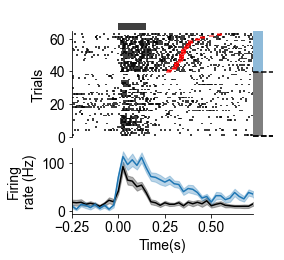

In [12]:
fig = plot_unit('07903-22-164t2', log_df, -0.25, 0.75, trial_type = 'Stim_Som_NoCue', bin_size = bin_size)

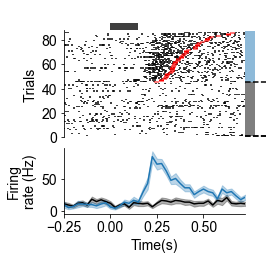

In [13]:
fig = plot_unit('07903-22-164t2', log_df, -0.25, 0.75, trial_type = 'Stim_Vis_NoCue', bin_size = bin_size)

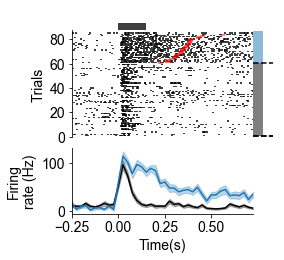

In [14]:
fig = plot_unit('07903-22-164t2', log_df, -0.25, 0.75, trial_type = '1CycStim_Som_NoCue', bin_size = bin_size)

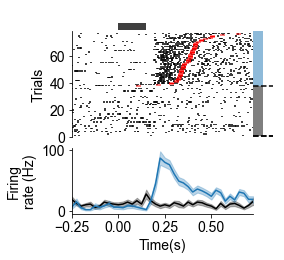

In [15]:
fig = plot_unit('07903-22-164t2', log_df, -0.25, 0.75, trial_type = '1CycStim_Vis_NoCue', bin_size = bin_size)

### load auc data

In [16]:
tactile_lick_noLick_aucs = pd.read_hdf(r'C:\Users\efink\Documents\DATA\Crossmodal_only\Touch_lick_no_lick_auc_2019-02-27.h5', 'table')
visual_lick_noLick_aucs = pd.read_hdf(r'C:\Users\efink\Documents\DATA\Crossmodal_only\Visual_lick_no_lick_auc_2019-02-27.h5', 'table')

In [17]:
visual_lick_noLick_aucs['mouse_name'].drop_duplicates().values

array(['EF0074', 'EF0076', 'EF0077', 'EF0079', 'EF0081', 'EF0083',
       'EF0084', 'EF0085', 'EF0088', 'EF0089', 'EF0091', 'EF0099',
       'EF0101', 'EF0102', 'EF0114'], dtype=object)

### filter auc data for tactile lick-right/ visual lick-left  data 

In [18]:
tactile_lick_noLick_aucs = tactile_lick_noLick_aucs.merge(unit_key_df['uni_id'].to_frame(), on = 'uni_id', how = 'right')
visual_lick_noLick_aucs = visual_lick_noLick_aucs.merge(unit_key_df['uni_id'].to_frame(), on = 'uni_id', how = 'right')
visual_lick_noLick_aucs.shape

(1539, 483)

# Identify units with a significant detect probability (DP) and define onset times

In [19]:
auc_col_names = tactile_lick_noLick_aucs.columns[tactile_lick_noLick_aucs.columns.str.contains('auc')]
low_conf_col_names = tactile_lick_noLick_aucs.columns[tactile_lick_noLick_aucs.columns.str.contains('low')]
up_conf_col_names =tactile_lick_noLick_aucs.columns[tactile_lick_noLick_aucs.columns.str.contains('up')]

In [20]:
# find bins where auc is significant 
raw_tac_sig_AUC = pd.DataFrame(~((tactile_lick_noLick_aucs.loc[:,low_conf_col_names].fillna(0.5) >= 0.5).as_matrix() & 
                    (tactile_lick_noLick_aucs.loc[:,up_conf_col_names].fillna(0.5) <= 0.5).as_matrix())*1, index = tactile_lick_noLick_aucs['uni_id'])

raw_vis_sig_AUC = pd.DataFrame(~((visual_lick_noLick_aucs.loc[:,low_conf_col_names].fillna(0.5) >= 0.5).as_matrix() & 
                    (visual_lick_noLick_aucs.loc[:,up_conf_col_names].fillna(0.5) <= 0.5).as_matrix())*1, index = visual_lick_noLick_aucs['uni_id'])

# identify direction of significant bins
auc_dir_t = (tactile_lick_noLick_aucs.loc[:,auc_col_names] >= 0.5)*1 + (tactile_lick_noLick_aucs.loc[:,auc_col_names] < 0.5)*-1
auc_dir_v = (visual_lick_noLick_aucs.loc[:,auc_col_names] >= 0.5)*1 + (visual_lick_noLick_aucs.loc[:,auc_col_names] < 0.5)*-1
auc_dir_v = (visual_lick_noLick_aucs.loc[:,auc_col_names] >= 0.5)*1 + (visual_lick_noLick_aucs.loc[:,auc_col_names] < 0.5)*-1
auc_dir_t.index = tactile_lick_noLick_aucs['uni_id']; auc_dir_t.columns = raw_tac_sig_AUC.columns
auc_dir_v.index = visual_lick_noLick_aucs['uni_id']; auc_dir_v.columns = raw_vis_sig_AUC.columns

raw_tac_sig_AUC = raw_tac_sig_AUC*auc_dir_t
raw_vis_sig_AUC = raw_vis_sig_AUC*auc_dir_v

In [21]:
# take running sum of bins to identify bins with consecutive significant bins
smooth_tac_sig_AUC = raw_tac_sig_AUC.apply(lambda y: np.convolve(y, [1,1], 'same'), axis = 1)
smooth_vis_sig_AUC = raw_vis_sig_AUC.apply(lambda y: np.convolve(y, [1,1], 'same'), axis = 1)

### to get the first bin of 2 that are significantly different from 0 need to subtract 1 from all_sig_tac/vis since convolve 
### was used with 'same' setting (otherwise would need to subtract 2 if setting was 'full')
all_sig_tac = (smooth_tac_sig_AUC.isin([2,-2])*1).apply(lambda y: np.where(y), axis = 1)
all_sig_tac = all_sig_tac.apply(lambda y: (y[0]-1)*bin_size-1 if len(y[0])>0 else [])

all_sig_vis = (smooth_vis_sig_AUC.isin([2,-2])*1).apply(lambda y: np.where(y), axis = 1)
all_sig_vis = all_sig_vis.apply(lambda y: (y[0]-1)*bin_size-1 if len(y[0])>0 else [])

### find first significant bin for each unit for each modality
all_first_sig_tac = all_sig_tac.apply(lambda y:  y[(y>=0) & (y<1)] if len(y)!=0 else []) 
all_first_sig_tac = all_first_sig_tac.apply(lambda y:  np.nan if len(y)==0 else np.min(y))

all_first_sig_vis = all_sig_vis.apply(lambda y:  y[(y>=0) & (y<1)] if len(y)!=0 else [])
all_first_sig_vis = all_first_sig_vis.apply(lambda y:  np.nan if len(y)==0 else np.min(y))
dp_onsets = pd.merge(all_first_sig_vis.to_frame(name = 'vis_dp_onset').reset_index(), all_first_sig_tac.to_frame(name = 'tac_dp_onset').reset_index(), how = 'outer')

# Find good example units that show range of responses

## sort units either by tac/vis auc ratio or mean auc

In [22]:
m_tac_cp = tactile_lick_noLick_aucs.loc[:, auc_col_names[39:50]].mean(axis = 1)
m_vis_cp = visual_lick_noLick_aucs.loc[:, auc_col_names[39:50]].mean(axis = 1)

ratio = m_vis_cp.values/m_tac_cp.values
ratio_ind = np.argsort(ratio)

high_mean = m_vis_cp.values*m_tac_cp.values
high_mean_ind = np.argsort(high_mean)[::-1]
                     
sorted_ratio_uni_ids = tactile_lick_noLick_aucs.iloc[ratio_ind]['uni_id']
sorted_mean_uni_ids = tactile_lick_noLick_aucs.iloc[high_mean_ind]['uni_id']

### generators that make flipping through units easy
ratio_unit_gen = (unit for unit in sorted_ratio_uni_ids)
high_mean_unit_gen = (unit for unit in sorted_mean_uni_ids)

In [23]:
### convert onsets to bin indeces
dp_onsets[['tac_dp_onset_inds', 'vis_dp_onset_inds']] = ((dp_onsets[['tac_dp_onset', 'vis_dp_onset']].fillna(-0)+1)/0.025).astype(int)

07401-18-161t1


(<Figure size 1080x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1941cbc2eb8>)

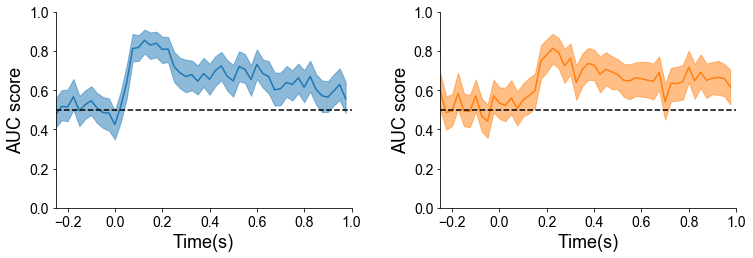

In [24]:
am.plot_auc(next(high_mean_unit_gen), tactile_lick_noLick_aucs, visual_lick_noLick_aucs, window = [-.25,1])

07603-04-162t1


(<Figure size 1080x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x196dc419e80>)

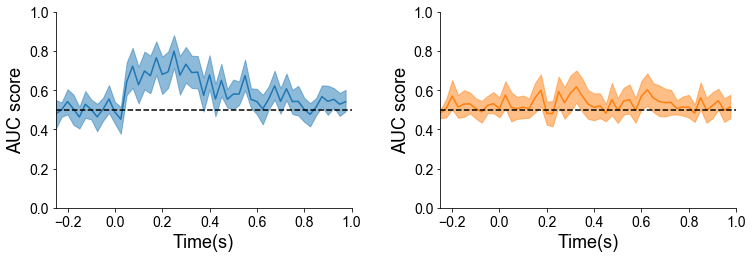

In [25]:
am.plot_auc('07603-04-162t1', tactile_lick_noLick_aucs, visual_lick_noLick_aucs, window = [-.25,1])

07401-09-164t3


(<Figure size 1080x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x19664a01f28>)

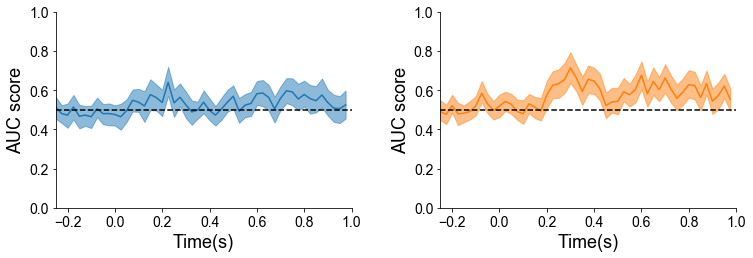

In [26]:
am.plot_auc('07401-09-164t3', tactile_lick_noLick_aucs, visual_lick_noLick_aucs, window = [-0.25,1])

07903-22-164t2


(<Figure size 1080x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1942162ef60>)

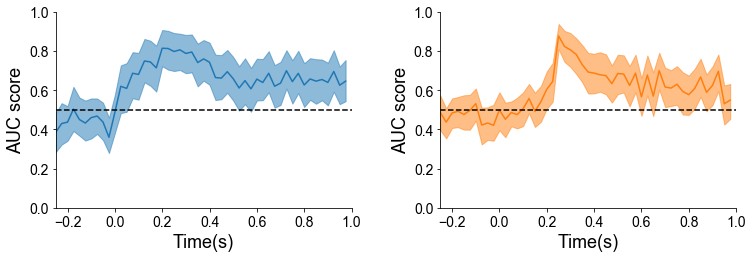

In [27]:
am.plot_auc('07903-22-164t2', tactile_lick_noLick_aucs, visual_lick_noLick_aucs, window = [-0.25,1])

In [28]:
example_units = ['07603-04-162t1', '07401-09-164t3', '07903-22-164t2']

# Plot scatter plot of touch DP and vis DP and plot modality preference index
* use any unit that has at a significant DP in at least one modality trial.
* average over the three seconds after stimulus onset

In [29]:
def plot_choice_prob_scatter(uni_ids, tac_auc_df, vis_auc_df, window, color, ax):
    tac = tac_auc_df.merge(uni_ids.to_frame(), on = 'uni_id')
    vis = vis_auc_df.merge(uni_ids.to_frame(), on = 'uni_id')
    tac['tac_cp'] = tac.iloc[:, window[0]:window[1]].mean(axis = 1)
    vis['vis_cp'] = vis.iloc[:, window[0]:window[1]].mean(axis = 1)
    ax.scatter(tac['tac_cp'], vis['vis_cp'], color = color, alpha = 0.3,clip_on=False, s = 10)
    ax.plot([0,1], [0,1], '--k')
    ax.plot([0,1], [0.5,0.5], 'k', alpha = 0.4)
    ax.plot([0.5,.5], [0,1],'k', alpha = 0.4)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False) 
    ax.set_ylim(0.3,0.9), ax.set_xlim(0.3,0.9)
    ax.set_xlabel('Mean touch dp')
    ax.set_ylabel('Mean visual dp')
    return tac[['uni_id', 'tac_cp']], vis[['uni_id', 'vis_cp']]

In [30]:
def calc_pref(mean_tac_dp, mean_vis_dp):
    pref = (abs(mean_tac_dp-0.5) - abs(mean_vis_dp-0.5))/(abs(mean_tac_dp-0.5) + abs(mean_vis_dp-0.5))
    return pref

In [31]:
all_sig_units = dp_onsets.loc[~dp_onsets[['vis_dp_onset', 'tac_dp_onset']].isnull().all(axis = 1), 'uni_id'].to_frame()
all_sig_units.shape

(1033, 1)

0.5239983404457086 0.5055925546448085
0.5119587312265101 0.5683528658114821
0.6008002462296093 0.5771132376395535


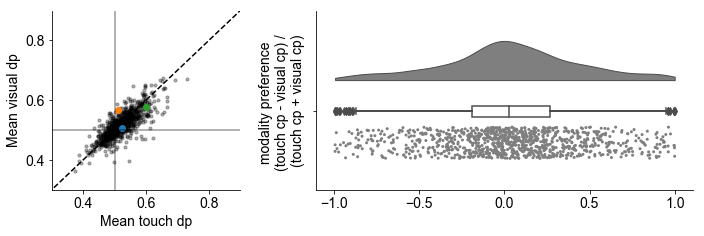

In [32]:
fig, axes = mpl.subplots(1,2, figsize = (10,3.5), gridspec_kw = {'width_ratios':[1, 2]})

mean_tac_cp, mean_vis_cp = plot_choice_prob_scatter(all_sig_units['uni_id'], tactile_lick_noLick_aucs, visual_lick_noLick_aucs, [45,159], 'k', axes[0])
for unit in example_units:
    x = mean_tac_cp.loc[mean_tac_cp['uni_id'] == unit, 'tac_cp'].values[0]
    y = mean_vis_cp.loc[mean_tac_cp['uni_id'] == unit, 'vis_cp'].values[0]
#     axes[0].annotate('local max', xy=(x, y), xytext=(3, 1.5),arrowprops=dict(facecolor='black', shrink=0.05))
    axes[0].scatter(x, y)
    print(x, y)
prefs = calc_pref(mean_tac_cp['tac_cp'], mean_vis_cp['vis_cp']).T
all_sig_units['prefs'] = prefs
                 
import ptitprince as pt
ax1 = axes[-1]
mpl.sca(ax1)
pt.RainCloud(x = prefs, ax = ax1, width_viol=0.5, width_box=0.075, move = 0.2, palette = ['C7'], orient = 'h')
ax1.spines['top'].set_visible(False); ax1.spines['right'].set_visible(False)
ax1.set_ylabel('modality preference \n(touch cp - visual cp) / \n(touch cp + visual cp)')
fig.tight_layout()
all_sig_units.to_hdf('modality_prefs.h5', 'fixed')
# fig.savefig('Lick-units_scatter.pdf', format='pdf', dpi=900, transparent = True)

### Visual DP more often than not begins later than touch DP. Taking average of all 3 seconds after stim onset tries to control for that when comparing between trial types. However, this dilutes the average DP for both trials significantly and takes into account time bins that are not relevant for DP (ie >1.5 seconds - this is well beyond most of the reaction times of the mice). One solution is to align trials to the detected onsets for each unit in each trial type and then average for the first 500ms

In [33]:
def align_auc(auc_df, onsets):
    auc_cols = ['uni_id'] + list(auc_df.columns[auc_df.columns.str.contains('auc')])
    auc_df = auc_df.loc[:, auc_cols]
    auc_df = auc_df.merge(onsets, on = 'uni_id')
    onset_column = onsets.columns[-1]
    aligned_auc = np.vstack(auc_df.apply(lambda x: [x[['uni_id']+x[onset_column]].values], axis = 1).values)
    aligned_auc_df = pd.DataFrame(aligned_auc[:,1:], index= aligned_auc[:,0])
    aligned_auc_df = aligned_auc_df.reset_index().rename(columns = {'index': 'uni_id'})
    return aligned_auc_df

In [34]:
dp_onsets['tac_dp_auc_window']= dp_onsets['tac_dp_onset_inds'].apply(lambda x: ['auc_score'+str(i) for i in range(x, x+40)])
dp_onsets['vis_dp_auc_window']= dp_onsets['vis_dp_onset_inds'].apply(lambda x: ['auc_score'+str(i) for i in range(x, x+40)])

In [35]:
aligned_tac_dp = align_auc(tactile_lick_noLick_aucs, dp_onsets[['uni_id','tac_dp_auc_window']])
aligned_vis_dp = align_auc(visual_lick_noLick_aucs, dp_onsets[['uni_id','vis_dp_auc_window']])

aligned_tac_dp = aligned_tac_dp.merge(dp_onsets[['uni_id', 'tac_dp_onset']])
aligned_vis_dp = aligned_vis_dp.merge(dp_onsets[['uni_id', 'vis_dp_onset']])

aligned_tac_dp.head()

,uni_id,0,1,2,3,4,5,6,7,8,...,31,32,33,34,35,36,37,38,39,tac_dp_onset
0,07401-03-161t1,0.470588,0.541299,0.452083,0.533578,0.530882,0.535294,0.546691,0.452083,0.497059,...,0.542157,0.491176,0.490319,0.504412,0.508211,0.455882,0.494485,0.526838,0.535049,NaN
1,07401-03-162t1,0.488725,0.494608,0.523529,0.584681,0.489706,0.467892,0.522672,0.517525,0.490074,...,0.544118,0.530392,0.541912,0.524632,0.491176,0.580025,0.536765,0.551225,0.535294,NaN
2,07401-03-162t2,0.529657,0.442892,0.460907,0.49902,0.53125,0.52549,0.547304,0.537745,0.455025,...,0.492279,0.449387,0.408578,0.45625,0.502941,0.515441,0.445098,0.491054,0.522426,NaN
3,07401-03-165t1,0.601471,0.570343,0.537255,0.595098,0.604657,0.529289,0.537132,0.590319,0.518627,...,0.584069,0.584681,0.510049,0.531863,0.551593,0.547794,0.545343,0.507475,0.556985,0.725
4,07401-03-165t2,0.395833,0.408456,0.434436,0.361152,0.435417,0.464216,0.456127,0.481618,0.490686,...,0.516299,0.545098,0.493873,0.53027,0.453186,0.49326,0.57402,0.48027,0.569118,0.500


In [45]:
prefs.shape

(1033,)

0.668296586059744 0.5275291199309751
0.5529021219344555 0.6135457932465573
0.7332745739947955 0.6913343965975544
t-test, p = 0.0000


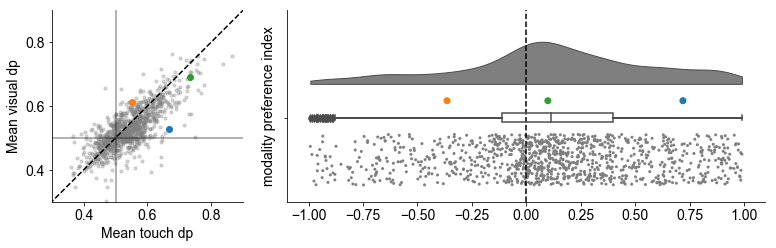

In [44]:
fig, axes = mpl.subplots(1,2, figsize = (11,3.7), gridspec_kw = {'width_ratios':[1, 2.5]})

mean_tac_cp, mean_vis_cp = plot_choice_prob_scatter(all_sig_units['uni_id'], aligned_tac_dp, aligned_vis_dp, [1,20], 'C7', axes[0])
for unit in example_units:
    x = mean_tac_cp.loc[mean_tac_cp['uni_id'] == unit, 'tac_cp'].values[0]
    y = mean_vis_cp.loc[mean_tac_cp['uni_id'] == unit, 'vis_cp'].values[0]
#     axes[0].annotate('local max', xy=(x, y), xytext=(3, 1.5),arrowprops=dict(facecolor='black', shrink=0.05))
    axes[0].scatter(x, y)
    print(x, y)
prefs = calc_pref(mean_tac_cp['tac_cp'], mean_vis_cp['vis_cp']).T
all_sig_units['prefs'] = prefs.values
example_prefs = all_sig_units[all_sig_units['uni_id'].isin(example_units)]

import ptitprince as pt
ax1 = axes[-1]
mpl.sca(ax1)
pt.RainCloud(x = prefs, ax = ax1, width_viol=0.5, width_box=0.05, move = 0.25, palette = ['C7'], orient = 'h', jitter = .15)
ax1.scatter(example_prefs['prefs'], [-.1]*3, c = ['C1', 'C0', 'C2'])
ax1.axvline(x = 0, linestyle = '--', color = 'k')
ax1.spines['top'].set_visible(False); ax1.spines['right'].set_visible(False)
ax1.set_ylabel('modality preference index')
fig.tight_layout()


print(f"t-test, p = {scipy.stats.ttest_1samp(prefs, 0)[1]:.4f}")
fig.savefig('Lick-units_scatter.pdf', format='pdf', dpi=900, transparent = True)

In [37]:
def cum_dist(arr, bins):
    hist = np.histogram(arr, bins = bins)
    cumsum = np.cumsum(hist[0])
    return [cumsum, hist[1]]

In [38]:
def prettify_ax(ax, x_label, y_label, y_lim = None, x_lim = None):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    if y_lim:
        ax.set_ylim(y_lim)
        
    if x_lim:
        ax.set_xlim(x_lim)
        
    return ax

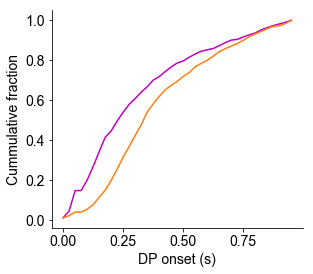

In [39]:
figure, ax = mpl.subplots(1,1,figsize = (4.5, 4))

cumsum = cum_dist(dp_onsets['tac_dp_onset'].dropna(), bins = np.arange(0,1, 0.025))
ax.plot(cumsum[1][:-1], cumsum[0]/dp_onsets['tac_dp_onset'].dropna().shape, color = 'm')

cumsum = cum_dist(dp_onsets['vis_dp_onset'].dropna(), bins = np.arange(0,1, 0.025))
ax.plot(cumsum[1][:-1], cumsum[0]/dp_onsets['vis_dp_onset'].dropna().shape, color = 'C1')

prettify_ax(ax, 'DP onset (s)', 'Cummulative fraction')

figure.savefig('DP_onset_cum_dist.pdf', format = 'pdf', dpi = 900)